
### VQE custom implementation


In [2]:
from math import pi
from typing import Dict, Any

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.providers.aer import AerSimulator

from qiskit.visualization import plot_histogram

from src.utils.ising import IsingModel
from src.utils.vqe import create_circ, qc_eval, obj_func

In [ ]:
# Use Aer's qasm_simulator
simulator_method = 'automatic'
simulator = AerSimulator()
# define circuit params 
num_qubits = 4
circ_depth = 1
# number circuit evaluations
shots = 64
num_param = num_qubits * (circ_depth + 1)

# define initial point
rng = np.random.default_rng(seed=42)
thetas0 = rng.random(num_param) * pi #np.zeros((circ_depth + 1, num_param // (circ_depth + 1)))
# define specific optimizer
method = 'COBYLA'
# set maximum optimizer steps
maxiter = 10
# alpha-th quantile to evaluate the loss
alpha = 25

In [ ]:
# define a ferro ising model
# with uniform external field
J=1
h=0.05*J

# hamiltonian is defined with +
# following http://spinglass.uni-bonn.de/ notation 
adja_dict = {}
field = np.zeros(num_qubits)
ext_field = h
for i in range(num_qubits):
    field[i] = ext_field
    if i == num_qubits - 1:
        continue
    adja_dict[(i, i+1)] = -J
# class devoted to set the couplings and get the energy 
ising = IsingModel(num_qubits, dim=1, adja_dict=adja_dict, ext_field=field)
print(ising.AdjaDict, ising.ExtField)

In [ ]:
qc = create_circ(thetas0, num_qubits, circ_depth)
# Draw the circuit
qc.draw()

In [ ]:
counts = qc_eval(qc, simulator, shots)
plot_histogram(counts)

In [ ]:
# test objective function
loss0 = obj_func(thetas0, simulator, num_qubits, circ_depth, shots, ising, alpha=alpha, verbose=True)
print(f"\nLoss at step 0 -> {loss0}")

In [ ]:
res = minimize(obj_func, thetas0, args=(simulator, num_qubits, circ_depth, shots, ising, alpha, True), 
               method=method, options={'maxiter': maxiter, 'disp':True})

In [ ]:
thetas_opt  = res.x
qc = create_circ(thetas_opt, num_qubits, circ_depth)
counts = qc_eval(qc, simulator, shots)
plot_histogram(counts)

ridefinire time to solution
in lidar loro trovano l'ottimo per ogni N numero di istanze parallele
carleo non-stoquastic QA con troyer

Noi geralizziamo facendo una funzione in 2D oppure numero di shots come parametro t in modo fa fare una famiglia di funzioni

Cosa vogliamo: resolurce to solution, moltiplico N_shot e N_step
ferromagnetico bias
mi servono alcuni for
- random su theta
- scalo su shots 
- scalo su step (maxiter)

alpha suggerito da loro (0.25)

valuto con RTS (TTS dove moltiplico per gli shots) non normalizzato per n_max

n.b. green quantum computing paper montangero

In [40]:
import numpy as np
from scipy.optimize import curve_fit
from math import ceil
from json import JSONEncoder
from matplotlib import pyplot as plt
from src.utils import collect_results

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, np.bool_):
            return bool(obj)
        if isinstance(obj, np.float64):
            return float(obj)
        return JSONEncoder.default(self, obj)

In [17]:
qubits = np.arange(4, 22, 2, dtype=int)
psucc, ts = collect_results(qubits)

directory: results/N4/
directory: results/N6/
directory: results/N8/
directory: results/N10/
directory: results/N12/
directory: results/N14/
directory: results/N16/
directory: results/N18/
directory: results/N20/


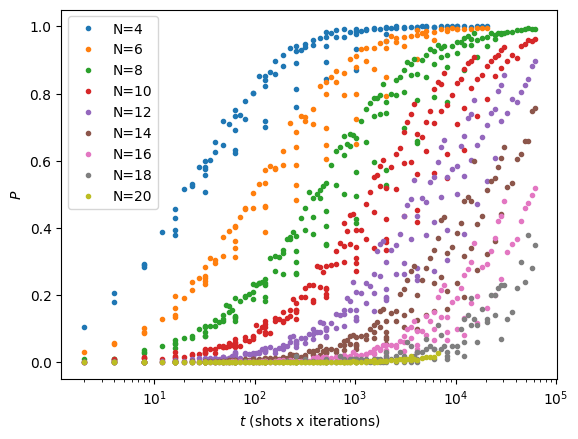

In [18]:
for i, (p,t) in enumerate(zip(psucc, ts)):
    p_t = np.vstack((t, p))
    p_t = p_t[:, np.argsort(p_t[0, :])]
    plt.plot(p_t[0], p_t[1], ".", label=f"N={4+i*2}")

    plt.xscale('log')
    plt.xlabel(r"$t$ (shots x iterations)")
    plt.ylabel(r"$P$")
    plt.legend()
    plt.savefig("p_t_n4-18.png")

In [19]:
def running_mean(x, n):
    cumsum = np.cumsum(np.pad(x, int(ceil(n/2)), mode='reflect')) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

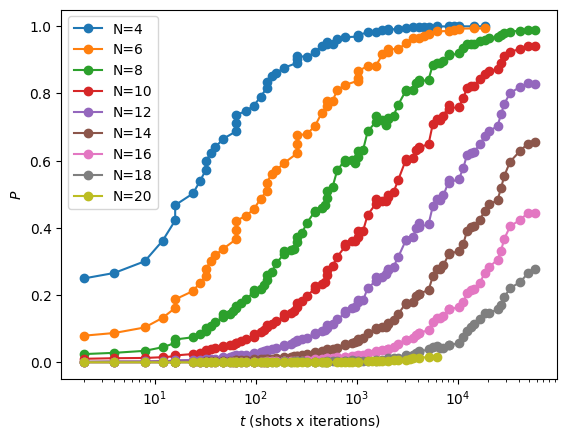

In [25]:
for i, (p,t) in enumerate(zip(psucc, ts)):
    p_t = np.vstack((t, p))
    p_t = p_t[:, np.argsort(p_t[0, :])]
    len_window = 12
    #p_t[1] = np.convolve(p_t[1], np.ones(len_window) / len_window, mode='same')
    p_t[1] = running_mean(p_t[1], len_window)
    plt.plot(p_t[0][::2], p_t[1][::2], "o-", label=f"N={4+i*2}")

    plt.xscale('log')
    plt.xlabel(r"$t$ (shots x iterations)")
    plt.ylabel(r"$P$")
    plt.legend()
    plt.savefig("p_t_n4-18.png")

In [26]:
def compute_r(p_s, p_d=0.99):
    rt = np.log(1-p_d)
    rt /= np.log(1-p_s)
    return rt

tts_list = []
for p,t in zip(psucc, ts):
    p = np.asarray(p)
    t = np.asarray(t)
    #print(p.shape,t.shape)
    mask =  p <= 0.005
    mask += p == 1.
    p = np.delete(p, mask)
    t = np.delete(t, mask)

    rt = compute_r(p)
    tts_list.append(t*rt)

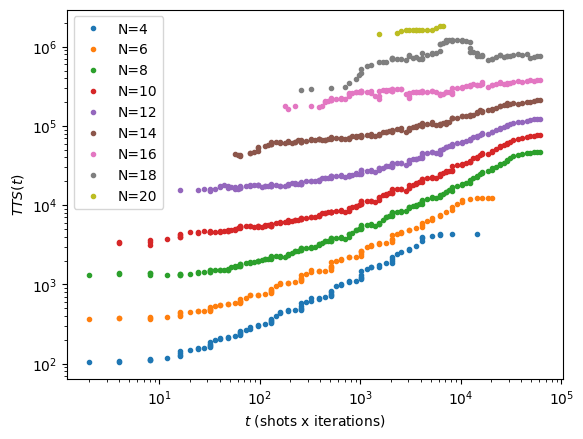

In [31]:
for i, (tts,t) in enumerate(zip(tts_list, ts)):
    t = np.asarray(t)
    mask = np.asarray(psucc[i]) <= 0.005
    mask += np.asarray(psucc[i]) == 1.
    t = np.delete(t, mask)

    tts_t = np.vstack((t, tts))
    tts_t = tts_t[:, np.argsort(tts_t[0, :])]
    # roll-mean
    len_window = 14
    tts_t[1] = running_mean(tts_t[1], len_window)
    plt.plot(tts_t[0], tts_t[1], ".", label=f"N={4+i*2}")

    plt.xscale('log')
    plt.yscale('log')
    #plt.xlim(1.5,50000)
    # plt.ylim(1,1000)
    plt.xlabel(r"$t$ (shots x iterations)")
    plt.ylabel(r"$TTS(t)$")
    plt.legend()
    plt.savefig("TTS-t.png")

In [42]:
def fun_exp(x, a, b):
    return a*2**(b*x)










[0.97433794 0.99650587]


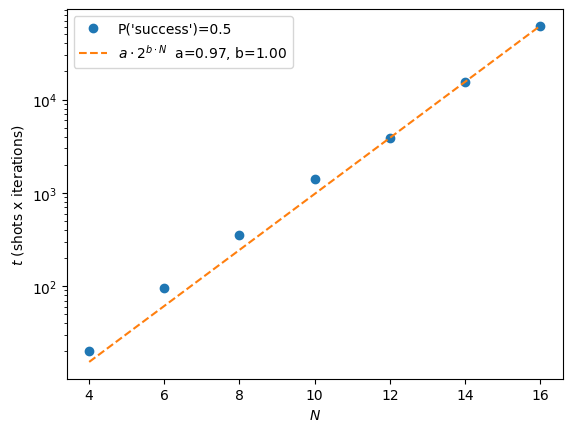

In [54]:
pt_all = []
for i, (p,t) in enumerate(zip(psucc, ts)):
    p_t = np.vstack((t, p))
    p_t = p_t[:, np.argsort(p_t[0, :])]
    pt_all.append(p_t)

min_psucc = 0.5
step_size = []
for i, pt in enumerate(pt_all):
    mask = pt[1] >= min_psucc
    print()
    if mask.sum() == 0:
        continue
    step_size.append(pt[0][mask][0])

x_axes = 4 + 2*np.arange(len(step_size))

popt, _ = curve_fit(fun_exp, x_axes, step_size)
print(popt)
plt.plot(x_axes, step_size, "o", label=f"P('success')={min_psucc}")
plt.plot(np.arange(4,17), fun_exp(np.arange(4,17), *popt), "--", label=r"$a \cdot 2^{b \cdot N}$" + f"  a={popt[0]:.2f}, b={popt[1]:.2f}")

plt.yscale('log')
plt.ylabel(r"$t$ (shots x iterations)")
plt.xlabel(r"$N$")

plt.legend()

plt.savefig("minit-succ50.png")

In [183]:
pt_all

[array([[1.0400e-01, 2.0600e-01, 2.8400e-01, 3.8700e-01, 4.5700e-01,
         5.1600e-01, 5.2500e-01, 5.8000e-01, 5.8000e-01, 6.0200e-01,
         6.2700e-01, 1.7900e-01, 2.9100e-01, 4.3000e-01, 5.3100e-01,
         5.9900e-01, 6.5600e-01, 7.1900e-01, 7.0800e-01, 7.3300e-01,
         7.3700e-01, 7.2400e-01, 2.9200e-01, 3.7800e-01, 5.5700e-01,
         6.4800e-01, 7.5200e-01, 7.7800e-01, 8.0200e-01, 8.5100e-01,
         8.5100e-01, 8.6300e-01, 8.5700e-01, 3.9400e-01, 5.7400e-01,
         6.9000e-01, 8.0200e-01, 8.4100e-01, 8.9600e-01, 9.1600e-01,
         9.3400e-01, 9.2700e-01, 9.3000e-01, 9.4700e-01, 5.0700e-01,
         6.3100e-01, 8.2100e-01, 8.8300e-01, 9.4000e-01, 9.3900e-01,
         9.4500e-01, 9.6600e-01, 9.8200e-01, 9.7900e-01, 9.6700e-01,
         6.2300e-01, 7.1900e-01, 8.9200e-01, 9.5900e-01, 9.6800e-01,
         9.8800e-01, 9.9100e-01, 9.8300e-01, 9.8500e-01, 9.8700e-01,
         9.9000e-01, 7.0000e-01, 8.1400e-01, 9.4100e-01, 9.6800e-01,
         9.9100e-01, 9.9100e-01, 9

In [63]:
p_succ = np.asarray(p_succ).reshape((-1,11))
sigma_p = np.asarray(sigma_p).reshape((-1,11))
p_everfound = np.asarray(p_everfound).reshape((-1, 11))
t_params = np.asarray(t_params)

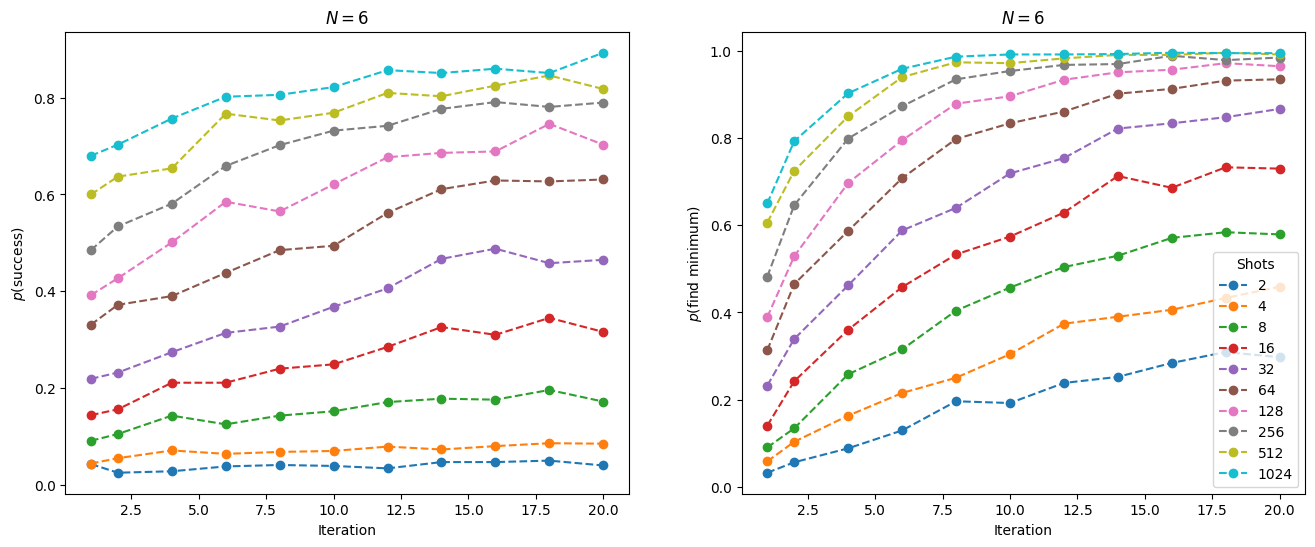

In [52]:
shots = 2**np.arange(1,11)#["2", "4", "8", "16", "32", "64", "128", "256", "512", "1024"] 
maxiter = [1] + list(range(2,22,2))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

for i, (s,e) in enumerate(zip(p_succ, p_everfound)):
    ax1.plot(maxiter, s, '--o', label=shots[i])
    ax2.plot(maxiter, e, '--o', label=shots[i])
    #ax2.errorbar(maxiter, d, yerr=sigma_p[i,:], label=legend[i], capsize=5)

ax1.set_title(r'$N=6$')
ax2.set_title(r'$N=6$')

ax1.set_xlabel('Iteration')
ax1.set_ylabel(r'$p$(success)')

ax2.set_xlabel('Iteration')
ax2.set_ylabel(r'$p$(find minimum)')

ax2.legend(title='Shots')

plt.show()

#plt.savefig("iterp_n6.png")

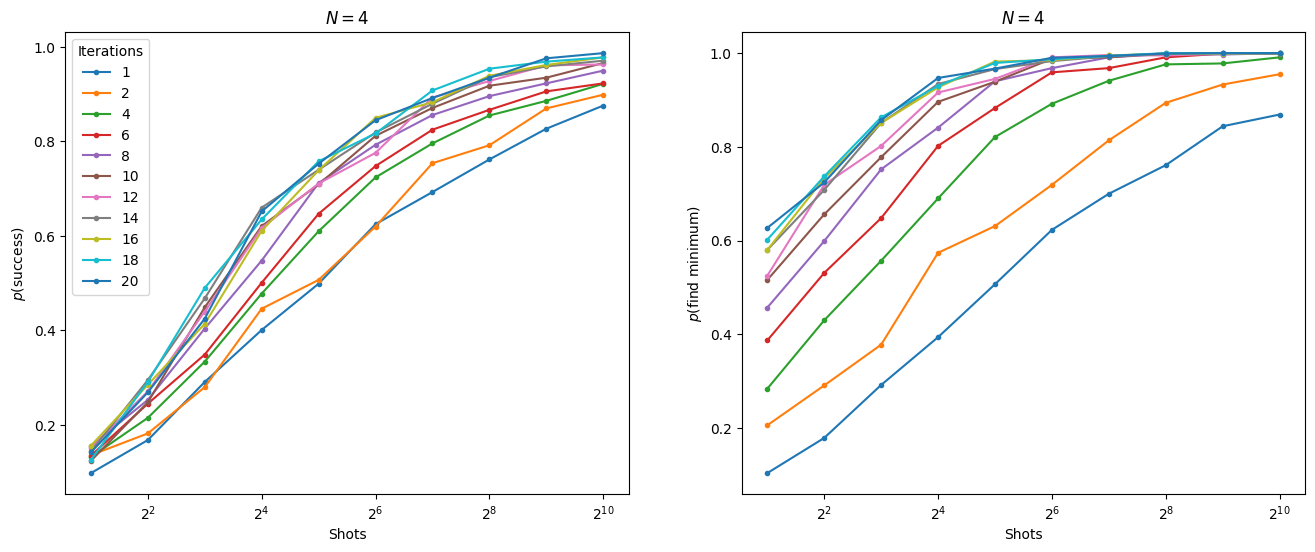

In [65]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

for i, (s,e) in enumerate(zip(p_succ.T, p_everfound.T)):
    ax1.plot(shots, s, '.-', label=maxiter[i])
    ax2.plot(shots, e, '.-', label=maxiter[i])
    #ax2.errorbar(shots, d, yerr=sigma_p[:,i], label=maxiter[i], capsize=4)

ax1.set_xscale('log', base=2)
ax2.set_xscale('log', base=2)

ax1.set_title(r'$N=4$')
ax2.set_title(r'$N=4$')

ax1.set_xlabel('Shots')
ax1.set_ylabel(r'$p$(success)')
ax1.legend(title="Iterations")

ax2.set_xlabel('Shots')
ax2.set_ylabel(r'$p$(find minimum)')

plt.savefig("shotp_n4.png")

In [45]:
p_t = np.vstack((t_params, p_everfound.reshape(-1)))
p_t = np.sort(p_t, axis=1)
print(p_t[:,:10])

[[ 2.     4.     4.     8.     8.     8.    12.    16.    16.    16.   ]
 [ 0.032  0.056  0.058  0.088  0.09   0.103  0.129  0.134  0.14   0.163]]


In [46]:
p_t6 = np.copy(p_t)

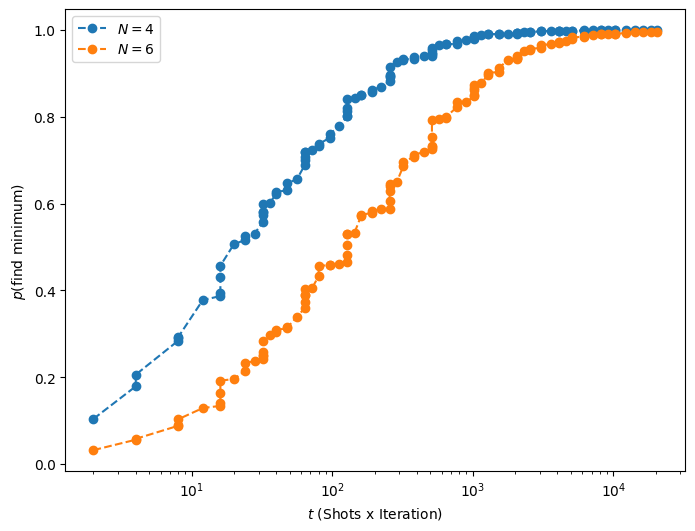

In [66]:
fig, ax1 = plt.subplots(1,1, figsize=(8,6))

ax1.plot(p_t4[0], p_t4[1], "--o", label=r"$N=4$")
ax1.plot(p_t6[0], p_t6[1], "--o", label=r"$N=6$")

ax1.set_xscale('log')

ax1.set_xlabel(r'$t$ (Shots x Iteration)')
ax1.set_ylabel(r'$p$(find minimum)')

ax1.legend()

plt.savefig("tp_n4-6.png")

In [1]:
plt.imshow(p_everfound)

plt.xlabel("Iteration")
plt.xticks(maxiter)

plt.ylabel("Shots")
#plt.yticks(shots)
plt.yscale('log', base=2)

plt.title(r"$N=6$")
plt.colorbar()

NameError: name 'plt' is not defined

moltiplico step e iteration ma mantengo il colore
per ogni size ho un valore e quindi un plot per tutte le taglie (size scaling)
salvare la migliore energia che trovo e quando la trovo